# Лабораторная работа №8

## Рекуррентные нейронные сети для анализа временных рядов

Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017.

Данные в виде csv-файла можно скачать на сайте _Kaggle_: https://www.kaggle.com/robervalt/sunspots/

### Задание 1

Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
BASE_DIR = '/content/drive/My Drive/Colab Files/mo-2'

import sys

sys.path.append(BASE_DIR)

import os

In [0]:
DATA_ARCHIVE_NAME = 'sunspots.zip'

LOCAL_DIR_NAME = 'sunspots'

In [0]:
from zipfile import ZipFile

with ZipFile(os.path.join(BASE_DIR, DATA_ARCHIVE_NAME), 'r') as zip_:
    zip_.extractall(LOCAL_DIR_NAME)

In [0]:
DATA_FILE_PATH = 'sunspots/Sunspots.csv'

In [0]:
import pandas as pd

all_df = pd.read_csv(DATA_FILE_PATH, parse_dates = ['Date'], index_col = 'Date')

In [7]:
print(all_df.shape)

(3252, 2)


In [8]:
all_df.keys()

Index(['Unnamed: 0', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive = seasonal_decompose(all_df['Monthly Mean Total Sunspot Number'], model = 'additive', extrapolate_trend = 'freq')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

In [0]:
import seaborn as sns

from matplotlib import rcParams

rcParams['figure.figsize'] = 11.7, 8.27

sns.set()

sns.set_palette(sns.color_palette('hls', 8))

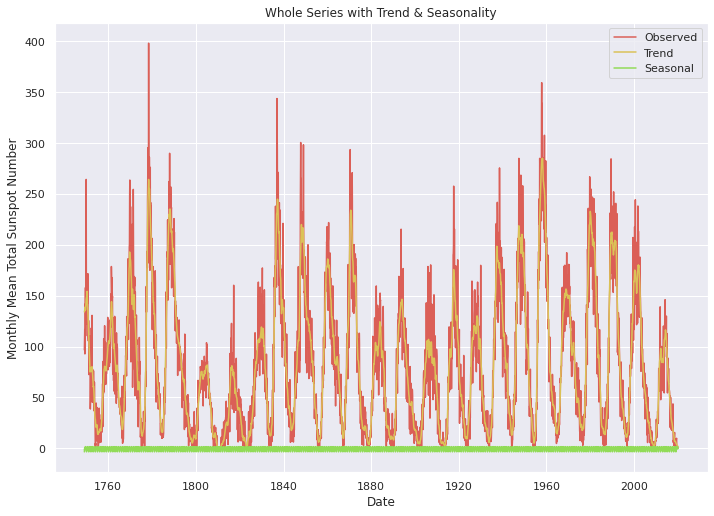

In [12]:
sns.lineplot(data = additive.observed, label = 'Observed')
sns.lineplot(data = additive.trend, label = 'Trend')
sns.lineplot(data = additive.seasonal, label = 'Seasonal')

plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')

plt.title('Whole Series with Trend & Seasonality')

plt.show()

Рассмотрим подробнее на небольшом промежутке:

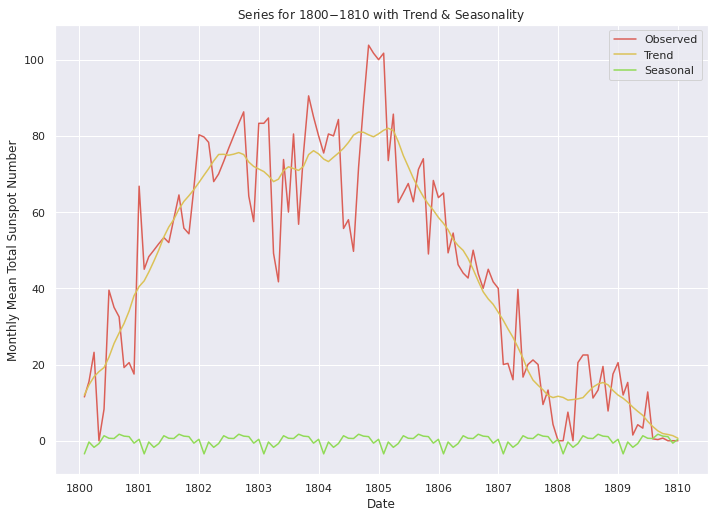

In [13]:
sns.lineplot(data = additive.observed['1800-01-01':'1810-01-01'], label = 'Observed')
sns.lineplot(data = additive.trend['1800-01-01':'1810-01-01'], label = 'Trend')
sns.lineplot(data = additive.seasonal['1800-01-01':'1810-01-01'], label = 'Seasonal')

plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')

plt.title('Series for 1800$-$1810 with Trend & Seasonality')

plt.show()

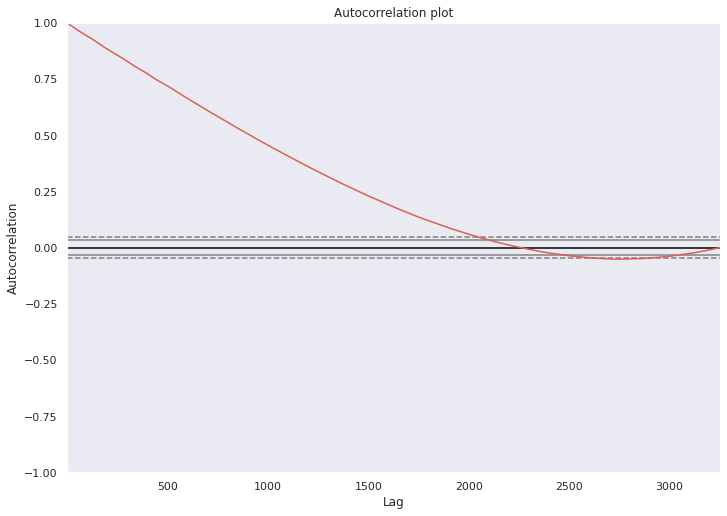

In [14]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(all_df.values.tolist())

plt.title('Autocorrelation plot')

plt.show()

### Задание 2

Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.

Этот шаг будет применён автоматически как параметр `validation_split` метода `model.fit()`.

### Задание 3

Примените модель _ARIMA_ для прогнозирования значений данного временного ряда.

In [15]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(all_df['Monthly Mean Total Sunspot Number'].values, order = (5,1,0))

model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3251
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -15102.868
Method:                       css-mle   S.D. of innovations             25.194
Date:                Wed, 15 Apr 2020   AIC                          30219.737
Time:                        08:07:20   BIC                          30262.344
Sample:                             1   HQIC                         30235.000
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0317      0.213     -0.149      0.882      -0.449       0.386
ar.L1.D.y     -0.4152      0.018    -23.719      0.000      -0.450      -0.381
ar.L2.D.y     -0.2979      0.019    -15.777      0.0

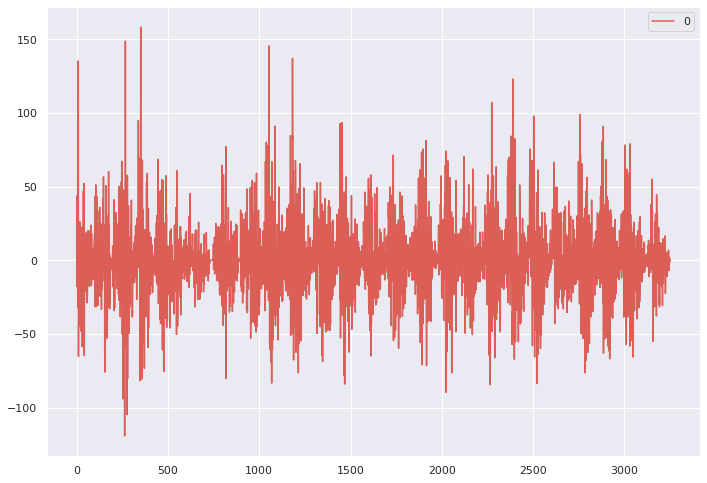

In [16]:
residuals = pd.DataFrame(model_fit.resid)

residuals.plot()

plt.show()

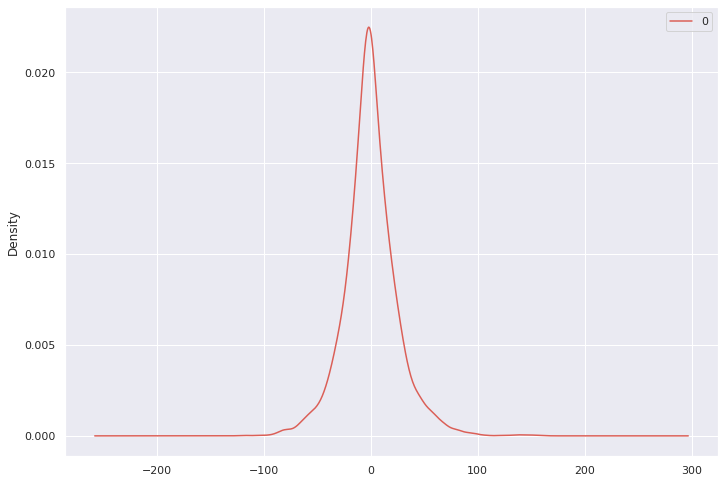

In [17]:
residuals.plot(kind = 'kde')

plt.show()

In [18]:
print(residuals.describe())

                 0
count  3251.000000
mean      0.003868
std      25.198623
min    -119.111207
25%     -13.116087
50%      -0.897181
75%      12.472338
max     158.110167


### Задание 4

Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

Сначала нужно создать датасет из данных.

In [61]:
! pip install tensorflow-gpu --pre --quiet

! pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 2.2.0rc3
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: astunparse, wheel, keras-preprocessing, wrapt, protobuf, opt-einsum, gast, absl-py, numpy, tensorboard, google-pasta, grpcio, scipy, six, h5py, tensorflow-estimator, termcolor
Required-by: 


In [0]:
TIME_STEPS = 8

In [0]:
X_ts = all_df['Monthly Mean Total Sunspot Number']

In [0]:
import numpy as np
from datetime import timezone

def timeseries_to_dataset(_X_ts, _y_ts, _time_steps):

    samples_n_ = len(_X_ts) - _time_steps

    X_ = np.zeros((samples_n_, _time_steps))
    y_ = np.zeros((samples_n_, ))

    for i in range(samples_n_):

        X_[i] = _X_ts[i:(i + _time_steps)]

        y_[i] = _X_ts[(i + _time_steps)]

    return X_[..., np.newaxis], y_

X, y = timeseries_to_dataset(X_ts, y_ts, TIME_STEPS)

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.Sequential()

model.add(LSTM(8, return_sequences = True, input_shape = X.shape[-2:]))
model.add(LSTM(8))
model.add(Dense(1))

In [140]:
model.compile(optimizer = 'adam',
              loss = 'mae',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 8, 8)              320       
_________________________________________________________________
lstm_12 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


In [141]:
model.fit(x = X, y = y, validation_split = 0.15, epochs = 100)

Epoch 1/100
87/87 [==============================] - 1s 15ms/step - loss: 17.9821 - accuracy: 0.0127 - val_loss: 16.5941 - val_accuracy: 0.0021
Epoch 2/100
87/87 [==============================] - 1s 6ms/step - loss: 17.6913 - accuracy: 0.0131 - val_loss: 16.4319 - val_accuracy: 0.0021
Epoch 3/100
87/87 [==============================] - 1s 6ms/step - loss: 17.6705 - accuracy: 0.0127 - val_loss: 16.5496 - val_accuracy: 0.0021
Epoch 4/100
87/87 [==============================] - 1s 6ms/step - loss: 17.5470 - accuracy: 0.0138 - val_loss: 16.8335 - val_accuracy: 0.0021
Epoch 5/100
87/87 [==============================] - 1s 6ms/step - loss: 17.9868 - accuracy: 0.0138 - val_loss: 16.8167 - val_accuracy: 0.0021
Epoch 6/100
87/87 [==============================] - 1s 6ms/step - loss: 17.8741 - accuracy: 0.0127 - val_loss: 16.5966 - val_accuracy: 0.0021
Epoch 7/100
87/87 [==============================] - 1s 6ms/step - loss: 17.7454 - accuracy: 0.0131 - val_loss: 16.3754 - val_accuracy: 0.002

### Задание 5

Сравните качество прогноза моделей.

Какой максимальный результат удалось получить на контрольной выборке?